# How to make a spectrogram
Spectrograms are important tools in phonetics, and it can be helpful to understand exactly how they are made. This tutorial steps through the key concepts of spectrograms without diving too deeply into the underlying mathematics.

We'll start by importing some standard scientific libraries, and setting up our notebook to plot our figures inline with the tutorial.

In [1]:
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('figure', figsize=(16, 4))

## Load audio data
We'll use `scipy.io.wavfile` to read the audio data. The `read` function returns a tuple containing the sampling frequency first, then an array of the data samples. Note that there are different "flavors" of wavfile that store audio data in different ways; for example, some wavfiles store the amplitude of each sample as an integer number of bits while others store amplitude as a decimal value between `-1.0` and `+1.0`. [The documentation for the `read` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html) explains that `scipy` preserves those differences, so here we'll explicitly convert our wavfile sample data to floating-point values between `-1.0` and `1.0`.  Side note: `scipy` won't read audio files that use 24 bits per sample to store the data (it *will* read 8-, 16-, or 32-bit audio files).  If you have a 24-bit audio file, you can use [the `wavio` module](https://pypi.python.org/pypi/wavio), or you can convert the file's bit depth before loading it with `scipy`.

In [2]:
sampling_frequency, wav_data = scipy.io.wavfile.read('23-09_NWM02.wav')

def convert_wav_to_float(data):
    if data.dtype == np.uint8:
        data = (data - 128) / 128.
    elif data.dtype == np.int16:
        data = data / 32768.
    elif data.dtype == np.int32:
        data = data / 2147483648.
    return data

wav_data = convert_wav_to_float(wav_data)

At this point we'll also create a vector of time points in seconds, so that when we plot the waveform or spectrogram, our x-axis will show time in seconds instead of sample numbers.

In [3]:
n_samples = len(wav_data)
total_duration = n_samples / sampling_frequency
sample_times = np.linspace(0, total_duration, n_samples)

At this point we can plot the waveform:

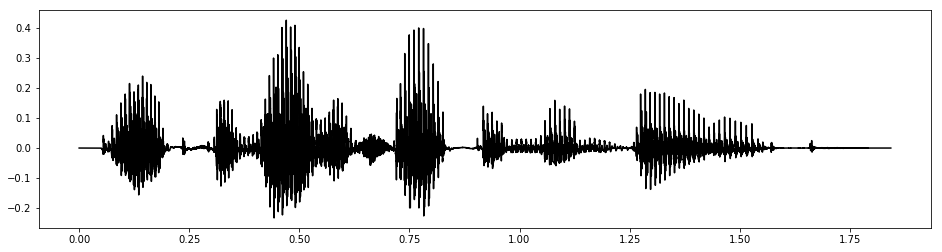

In [4]:
plt.plot(sample_times, wav_data, color='k');

## What goes into a spectrogram?
Other than the audio data, we need to specify several other parameters to make a spectrogram. Since a spectrogram is made by analysing the frequencies present in short segments of the audio (sometimes called "analysis frames"), we have to define how long we want those short segments to be. The first choice, then, is to specify the **window length**. If you're familiar with the notion of "narrowband" versus "wideband" spectrograms, window length is the parameter that underlies the difference between them: the longer the window length, the more precisely you can estimate the exact frequencies that are present within that window (and hence, the narrower the frequency bands will be; thus "narrowband" spectrograms have relatively longer window lengths).  However, the whole window is analyzed as a chunk, and yields one column of values in the spectrogram, so longer windows means each column is "wider" in time, which means less precise information about *when* certain frequency components were loud or soft. Below, when we write a spectrogram function, we'll set our default window duration at 5 ms, which is typical for a wideband spectrogram (pretty good temporal resolution, and frequency resolution that blurs individual harmonics, making vocal tract formants easier to see), but we can always override the default by passing in a different value.

A second aspect of the window that we must specify is its **shape**.  The shape determines how each sample within the analysis frame gets weighted (i.e., whether they are all weighted equally, or whether some get more weight than others when performing the fourier analysis). You might think that weighting all samples equally would be the best approach, but in fact that is not the case. Instead, it turns out that tapering off at the beginning and end of the window, and weighting the samples in the middle more strongly, tends to yield a more useful picture of the signal. For speech analysis, the best choice is a [Gaussian window](https://en.wikipedia.org/wiki/Gaussian_function), because (unlike other window shapes) it does not result in substantial [ringing](https://en.wikipedia.org/wiki/Ringing_artifacts) ("ringing" is alternating bands of spurious energy in frequencies above and below the frequencies actually present in the signal). Here's an example of what ringing looks like: a spectrogram of a 250 Hz sine wave made with a Bartlett (triangular) window has intense horizontal stripes indicating ringing (left plot); the same signal analyzed with a Gaussian window does not.

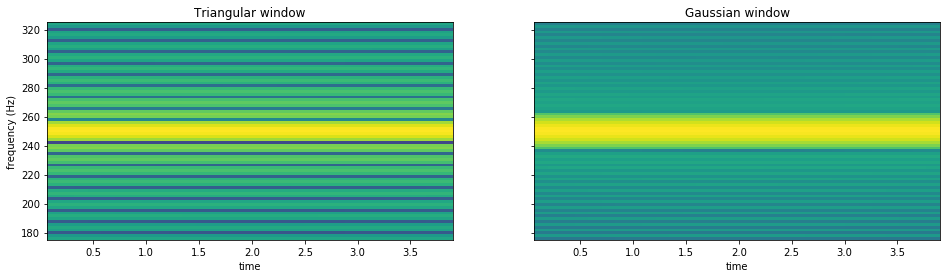

In [5]:
duration = 4
sine_frequency = 250
time = np.linspace(0, duration, 1000 * duration)
sine_wave = np.sin(2 * np.pi * sine_frequency * time)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
kwargs = dict(x=sine_wave, Fs=1000, NFFT=256, noverlap=128, pad_to=512)
axs[0].specgram(window=np.bartlett(256), **kwargs)
axs[1].specgram(window=scipy.signal.gaussian(256, int(256 / 6)), **kwargs)
axs[0].set_ylim(175, 325)
axs[0].set_ylabel('frequency (Hz)')
axs[0].set_xlabel('time')
axs[1].set_xlabel('time')
axs[0].set_title('Triangular window')
axs[1].set_title('Gaussian window');

If the signal is just a single sine wave like here, the ringing is maybe not such a big deal (we can still tell what the dominant frequency is).  However, when lots of frequencies are present at different intensities (like the harmonics in a speech sound), ringing can really obscure what is going on.  Since we'll pretty much always want a Gaussian window, we'll hard-code that into our custom spectrogram function; if you ever need a different window shape you can edit the function, or use the function `scipy.signal.spectrogram`.

Another quantity that goes into making a spectrogram is how far apart we want our analysis frames to be, a parameter called the **step size**.  Usually, the step size is smaller than the window length, so that there is *overlap* between adjacent windows.  Exactly how much overlap to include is a trade-off between computation time (more windows = slower computation) and how much detail we want to see.  For a Gaussian window, the step size never needs to be smaller than $\frac{\textrm{window length}}{8 \sqrt{\pi}}$.  Making the windows overlap any more than that only adds redundant information, unnecessarily slowing down the computation.  In our function, we'll default to using that formula inside our function to make our spectrograms show as much detail as possible without doing any unnecessary computations, but we'll allow the user to pass in a different step size if they want to.

Finally, we have to decide how to map energy in a particular frequency band and time window into a particular color value. This is usually done by specifying the **dynamic range**, or the ratio between the quietest part that is treated as non-zero, and loudest part.  For speech, there is a difference of 100 dB or more between the loudest parts of the recording and the quietest of the higher formants, so we'll set the default at 120 dB. For field recordings with a lot of background noise, you may want to set this value lower, to increase the contrast between the loud parts of the speech and the background noise.

## Putting it all together

There are two more parameters to our function we haven't yet discussed. The first is `cmap` which lets you specify a color mapping different than the default grayscale. The second is `ax` which lets you plot the spectrogram on a pre-created `matplotlib.axes.Axes` object (this can be handy if you want to plot the waveform and spectrogram in adjacent subplots, for example).  Here's the function, with comments every few lines explaining what we're doing.

In [6]:
def gaussian_spectrogram(x, fs, window_dur=0.005, step_dur=None, dyn_range=120, 
                         cmap=None, ax=None):
    from scipy.signal import spectrogram, gaussian
    from matplotlib.colors import LogNorm
    from matplotlib.cm import get_cmap
    
    # set default for step_dur, if unspecified. This value is optimal for Gaussian windows.
    if step_dur is None:
        step_dur = window_dur / np.sqrt(np.pi) / 8.
    
    # convert window & step durations from seconds to numbers of samples (which is what
    # scipy.signal.spectrogram takes as input).
    window_nsamp = int(window_dur * fs * 2)
    step_nsamp = int(step_dur * fs)
    
    # make the window. A Gaussian filter needs a minimum of 6σ - 1 samples, so working
    # backward from window_nsamp we can calculate σ.
    window_sigma = (window_nsamp + 1) / 6
    window = gaussian(window_nsamp, window_sigma)
    
    # convert step size into number of overlapping samples in adjacent analysis frames
    noverlap = window_nsamp - step_nsamp
    
    # compute the power spectral density
    freqs, times, power = spectrogram(x, detrend=False, mode='psd', fs=fs,
                                      scaling='density', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)

    p_ref = 2e-5  # 20 μPa, the standard reference pressure for sound in air

    # set lower bound of colormap (vmin) from dynamic range. The upper bound defaults
    # to the largest value in the spectrogram, so we don't need to set it explicitly.
    dB_max = 10 * np.log10(power.max() / (p_ref ** 2))
    vmin = p_ref * 10 ** ((dB_max - dyn_range) / 10)

    # set default colormap, if none specified
    if cmap is None:
        cmap = get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()

    # other arguments to the figure
    extent = (times.min(), times.max(), freqs.min(), freqs.max())

    # plot
    ax.imshow(power, origin='lower', aspect='auto', cmap=cmap,
              norm=LogNorm(), extent=extent, vmin=vmin, vmax=None)
    return ax

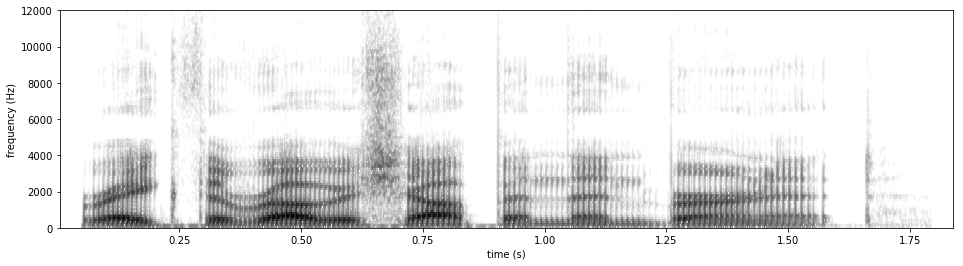

In [7]:
ax = gaussian_spectrogram(wav_data, sampling_frequency)
ax.set_ylim(0, 12000)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)');

## Notes

For those used to spectrograms in [Praat](http://www.fon.hum.uva.nl/praat/), note that the calculation here is slightly different.  Praat converts power spectral density from units of Pa²/Hz into dB/Hz before displaying a spectrogram, like this:

```python
log_psd = 10 * np.log10(power / (p_ref ** 2))
```

where `p_ref` is 20 μPa (the standard reference pressure for sound in air).  Instead, here the original power spectral density is used, along with a logarithmic color mapping (that's what `LogNorm()` does in the call to `ax.imshow()` near the end of the `gaussian_spectrogram` function).  This approach seems to make higher-frequency energy more visible compared to Praat's approach (which Praat mitigates by using "pre-emphasis" on the spectrogram to attenuate the lower frequencies).  Here's what the difference looks like:

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


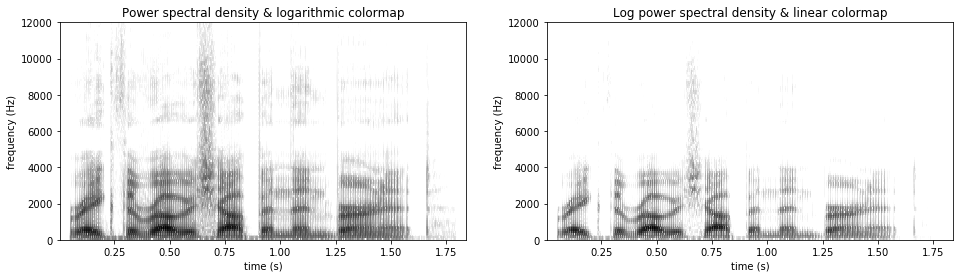

In [8]:
def praat_spectrogram(x, fs, window_dur=0.005, dyn_range=120, ax=None):
    # this function is less flexible than the other (to make it shorter, 
    # since it's just for demo purposes).
    from scipy.signal import spectrogram, gaussian
    from matplotlib.cm import get_cmap
    
    step_dur = window_dur / np.sqrt(np.pi) / 8.
    window_nsamp = int(window_dur * fs * 2)
    step_nsamp = int(step_dur * fs)
    window_sigma = (window_nsamp + 1) / 6
    window = gaussian(window_nsamp, window_sigma)
    noverlap = window_nsamp - step_nsamp
    freqs, times, power = spectrogram(x, detrend=False, mode='psd', fs=fs,
                                      scaling='density', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)
    p_ref = 2e-5
    log_psd = 10 * np.log10(power / (p_ref ** 2))  # key difference
    dB_max = log_psd.max()
    vmin = p_ref * 10 ** ((dB_max - dyn_range) / 10)
    cmap = get_cmap('Greys')
    if ax is None:
        fig, ax = plt.subplots()
    extent = (times.min(), times.max(), freqs.min(), freqs.max())
    # next line: pass `log_psd` instead of `power`; no `LogNorm`
    ax.imshow(log_psd, origin='lower', aspect='auto', cmap=cmap,
              extent=extent, vmin=vmin, vmax=None)
    return ax


fig, axs = plt.subplots(1, 2)
ax = gaussian_spectrogram(wav_data, sampling_frequency, ax=axs[0])
ax.set_ylim(0, 12000)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_title('Power spectral density & logarithmic colormap')

ax = praat_spectrogram(wav_data, sampling_frequency, ax=axs[1])
ax.set_ylim(0, 12000)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_title('Log power spectral density & linear colormap');

You can probably see that for most phonetic analysis, either one will probably work fine (the first 4-5 formants are visible in both, and the temporal and spectral resolution is the same).  In fact, the spectrogram *objects* in Praat contain the power spectral density numbers; it's only when displaying spectrograms on screen that Praat uses the log-transformed version.